# Machine Learning Models for Fraud Classification

In this notebook I will create some ML models to find the model that best suits the frauds in the credit card transactions, then I will use this model for the Real Time Fraud Detection pipeline. I will try with the following models:

- LogisticRegression
- Random Trees
- XGBoost

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score
)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/synthetic_transactions.csv')
df.head()

,transaction_id,user_id,amount,currency,category,timestamp,location,is_fraud
0,81eb959b-22d3-4e31-8378-d37af09c3ac9,1048,408.98,USD,Entertainment,2025-08-28T14:51:42.963443,BS,0
1,43749e52-58fc-48f0-87b2-7ea914f4ca26,1919,68.08,USD,Entertainment,2025-08-14T19:03:42.964477,RS,0
2,fa4e552f-24d3-4b7f-8bbb-43f932414c2d,1356,167.99,USD,Books,2025-08-12T09:01:42.964477,MU,0
3,bf80c618-5825-4fde-a8d4-8efa619c56d6,2300,24.50,USD,Parking,2025-08-15T01:09:42.964477,SN,0
4,b3c9c70c-de55-46e5-a378-8341c2298988,2552,25.37,USD,Health & Fitness,2025-08-08T10:35:42.964477,TJ,0


## Feature Engineering

In this part of the notebook I will prepare the data for the machine learning models, doing the following:

- Drop the irrelevant variables:
    - UserId
    - TransactionId
    - Currency (all the transactions are in USD)
- Get the hour of the transactions
- Convert the Location and Category into One Hot Encoding

I could add features for each user, but since the dataset is small and there aren't enough users nor purchases to find patterns, I won't do anything for now. 

In [3]:
# Drop irrelevant variables
df = df.drop(columns=['user_id', 'transaction_id', 'currency'])

In [4]:
# Get the hour of the transactions
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df = df.drop(columns=['timestamp'])
df.head()

,amount,category,location,is_fraud,hour
0,408.98,Entertainment,BS,0,14
1,68.08,Entertainment,RS,0,19
2,167.99,Books,MU,0,9
3,24.50,Parking,SN,0,1
4,25.37,Health & Fitness,TJ,0,10


In [5]:
# One-hot encode 'category' and 'location' columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_df = pd.DataFrame(
    encoder.fit_transform(df[['category', 'location']]),
    columns=encoder.get_feature_names_out(['category', 'location']),
    index=df.index  # ensure index aligns for concat
)

# Concatenate numerical and encoded categorical features
df_final = pd.concat([df.drop(columns=['category', 'location']), encoded_df], axis=1)
df_final.head()

,amount,is_fraud,hour,category_Books,category_Charity,category_Clothing,category_Coffee Shops,category_Cryptocurrency,category_Education,category_Electronics,...,location_VC,location_VE,location_VN,location_VU,location_WS,location_YE,location_ZA,location_ZM,location_ZW,location_nan
0,408.98,0,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,68.08,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,167.99,0,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24.50,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25.37,0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Split the dataset
X = df_final.drop(columns=['is_fraud'])
y = df_final['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((8000, 227), (2000, 227))

## Machine Learning Models

In this part I will crate functions to evaluate the models, since all the models I'll test will use the same metrics

In [7]:
def classification_report_matrix(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

In [8]:
def confusion_matrix_plot(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", 
        xticklabels=['Non Fraud', 'Fraud'], yticklabels=['Non Fraud', 'Fraud']
    )
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.title("Confusion Matrix")
    plt.show()

### Metrics

Before procedding with the models I will refresh myself of the metrics for the fraud case:

- Accuracy: Percentage of all predictions that are correct. Can be misleading with imbalanced data.
- Precision: Of all the transactions flagged as fraud, how many were actually fraud?.
    - High precision → fewer false alarms (less wasted time investigating legit transactions).
- Recall: Of all the fraud transactions, how many did we catch?.
    - High recall → very few fraud cases are missed.
- F1-score: Harmonic mean of precision and recall — balances the two when both matter.

So the most important metrics are **Precision** and **Recall** for the fraud class, I would focus more on Recall, because I prefer investigate legit transactions than miss fraud cases.

### Logistic Regression w Class Weights

In [9]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [10]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9325


In [11]:
classification_report_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           0     0.9967    0.9330    0.9638      1925
           1     0.3485    0.9200    0.5055        75

    accuracy                         0.9325      2000
   macro avg     0.6726    0.9265    0.7346      2000
weighted avg     0.9724    0.9325    0.9466      2000



- **Class 0 (legit / non-fraud)**  
  - *Precision = 0.9967*: Out of all transactions predicted as "non-fraud," 99.67% were correct.  
  - *Recall = 0.9330*: The model correctly identified 93.30% of all real non-fraud cases.  
  - *F1-score = 0.9638*: Strong balance between precision and recall, meaning the model is very reliable at recognizing legitimate transactions.

- **Class 1 (fraud)**  
  - *Precision = 0.3485*: Out of all transactions predicted as "fraud," only 34.85% were actually fraud → many false positives.  
  - *Recall = 0.9200*: The model captured 92% of all actual frauds → very strong at catching fraud.  
  - *F1-score = 0.5055*: The balance between precision and recall is moderate, reflecting the tradeoff: high recall but low precision.

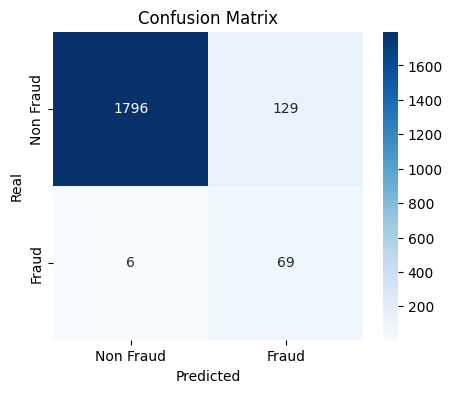

In [12]:
confusion_matrix_plot(y_test, y_pred)

- **True Negatives (TN = 1796)**: Legitimate transactions correctly identified as non-fraud.  
- **False Positives (FP = 129)**: Legitimate transactions incorrectly flagged as fraud (false alarms).  
- **False Negatives (FN = 6)**: Fraudulent transactions missed by the model.  
- **True Positives (TP = 69)**: Fraudulent transactions correctly identified as fraud.  

The model **catches most fraud cases (high recall)**, only missing 6 out of 75. However, it produces 129 false alarms, which reduces precision. But Overall I think its a good model since in this tradeoff is better to investigate extra cases than to miss fraud.

### Random Tree

In [13]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [14]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9835


In [15]:
classification_report_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           0     0.9856    0.9974    0.9915      1925
           1     0.9038    0.6267    0.7402        75

    accuracy                         0.9835      2000
   macro avg     0.9447    0.8120    0.8658      2000
weighted avg     0.9826    0.9835    0.9821      2000



- **Class 0 (legit / non-fraud)**  
  - *Precision = 0.9856*: Out of all transactions predicted as "non-fraud," 98.56% were correct.  
  - *Recall = 0.9974*: The model correctly identified 99.74% of all real non-fraud cases.  
  - *F1-score = 0.9915*: Strong balance between precision and recall, meaning the model is very reliable at recognizing legitimate transactions.

- **Class 1 (fraud)**  
  - *Precision = 0.9038*: Out of all transactions predicted as "fraud," 90.38% were actually fraud → low false positives.  
  - *Recall = 0.6267*: The model captured 62% of all actual frauds → strong at catching fraud, but worse than Logistic Regression.  
  - *F1-score = 0.7052*: The balance between precision and recall is moderate, reflecting the tradeoff: high precison but moderate recall.

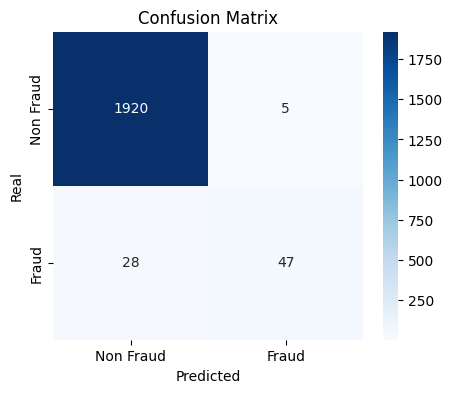

In [16]:
confusion_matrix_plot(y_test, y_pred)

This random forest perfom better classifying correct the non fraud transactions, however it performs worse than the logistic regression model in detecting the frauds, it misses almost 5 times more than logistic regression, but this model do not has a lot of false positives. 

In summary this models performs better than LR talking in numbers, but it misses more frauds, so I will preffer the LR model, now lets look the XGBoost case.

### XGBoost

In [17]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train), eval_metric='aucpr', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [18]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.977


In [19]:
classification_report_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           0     0.9916    0.9844    0.9880      1925
           1     0.6629    0.7867    0.7195        75

    accuracy                         0.9770      2000
   macro avg     0.8273    0.8855    0.8538      2000
weighted avg     0.9793    0.9770    0.9779      2000



- **Class 0 (legit / non-fraud)**  
  - *Precision = 0.9916*: Out of all transactions predicted as "non-fraud," 99.16% were correct.  
  - *Recall = 0.9844*: The model correctly identified 98.44% of all real non-fraud cases.  
  - *F1-score = 0.9880*: Strong balance between precision and recall, meaning the model is the most reliable at recognizing legitimate transactions.

- **Class 1 (fraud)**  
  - *Precision = 0.6629*: Out of all transactions predicted as "fraud," 66.29% were actually fraud → moderate false positives.  
  - *Recall = 0.7867*: The model captured 78% of all actual frauds → strong at catching fraud.  
  - *F1-score = 0.7195*: The balance between precision and recall is moderate, reflecting the tradeoff: moderate precison and moderate recall.
    

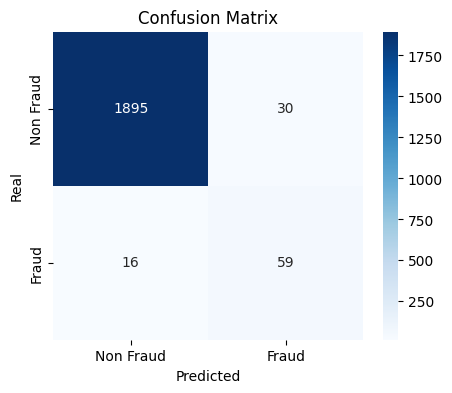

In [20]:
confusion_matrix_plot(y_test, y_pred)

The XGboost model is an intermediate between the Logistic Regression and the Random Forest model, the LR one was very good catching frauds but I had a lot of false positives, the RF had low false positives but misses more frauds than the LR and the XGBoost has moderate false positives and moderate misses.

So I think this is the better one, so I will imporve the model by searching the best parameters with grid search.

### Improving XGBoost

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.5],
    'scale_pos_weight': [int((len(y_train) - sum(y_train)) / sum(y_train))]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1.0], 'gamma': [0, 0.1, 0.5],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 7], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [300, 500], 'scale_pos_weight': [25],
                         'subsample': [0.7, 1.0]},
             scoring='f1', verbose=2)

In [22]:
# Print best parameters and best score
for param in grid_search.best_params_:
    print(f"{param}: {grid_search.best_params_[param]}")
print("Best F1-score:", grid_search.best_score_)

colsample_bytree: 1.0
gamma: 0.1
learning_rate: 0.1
max_depth: 5
min_child_weight: 1
n_estimators: 500
scale_pos_weight: 25
subsample: 1.0
Best F1-score: 0.7671303865329924


In [28]:
# Create model with best parameters
model = xgb.XGBClassifier(
        colsample_bytree=1.0,
        gamma=0.1,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        n_estimators=500,
        scale_pos_weight=25,
        subsample=1.0,
        eval_metric="logloss"
)

# Fit model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

In [29]:
classification_report_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           0     0.9922    0.9849    0.9885      1925
           1     0.6742    0.8000    0.7317        75

    accuracy                         0.9780      2000
   macro avg     0.8332    0.8925    0.8601      2000
weighted avg     0.9802    0.9780    0.9789      2000



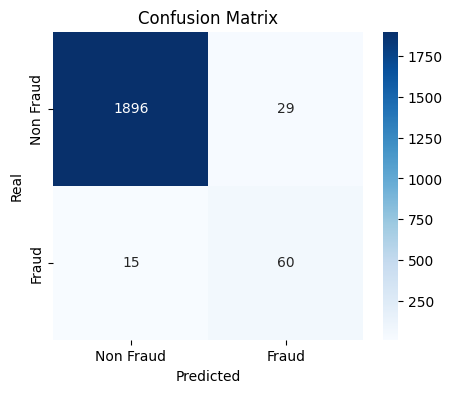

In [27]:
confusion_matrix_plot(y_test, y_pred)

Now I am much more satisfy with this model, I can go beyond and apply more advanced topics like SMOTE for class imbalance, but for now I am pleased, since:

- Out of all transactions predicted as "non-fraud," 99.22% were correct. 
- The model correctly identified 98.49% of all real non-fraud cases.  
- Out of all transactions predicted as "fraud," 67.42% were actually fraud → few false positives. 
- The model captured 80% of all actual frauds → very strong at catching fraud.  

So the model has a good precision in both classes, meaning there are few false alarms (less wasted time investigating legit transactions) and the recall was also higher, meaning there are very few fraud cases missed.